In [1]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams

In [3]:
def read_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
    
def dump_pickle(filepath, obj):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

## Предыдущие результаты замеров точности

In [4]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')
points_to_centers_3_4 = read_pickle('../dataset/100_points_to_cell_centers_12cells_3x4.pickle')

In [5]:
ideal_means_6_8 = read_pickle('../dataset/ideal_means_48cells_6x8.pickle')
predicted_means_6_8 = read_pickle("../dataset/predicted_means_48cells_6x8.pickle")

ideal_means_3_4 = read_pickle('../dataset/ideal_means_12cells_3x4.pickle')
predicted_means_3_4 = read_pickle("../dataset/predicted_means_12cells_3x4.pickle")

Это уже итоговые результаты: одно значение - средняя вероятность попадания в нужный квадрат для одной картинки. Нужны немного другие значения, так что придётся пересчитать.

## Более подробные замеры точности

In [6]:
predictions_folder = '../dataset/predictions/'
predicts_osm_folder = 'predicts_osm'
orig_osm_objects_path = '../dataset/osm_objects/'

In [7]:
train_val_test = read_pickle("../dataset/train_val_test_split.pickle")
test_ids = train_val_test['test']

In [8]:
predicts_osm_objects_path = os.path.join(predictions_folder, predicts_osm_folder)

In [9]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print("Sectors count:", sectors_count)

Sectors count: 616


### Все вероятности для одной точки

#### Построение круговых диаграмм для изображения

In [10]:
img_id = test_ids[0]
filename_pickle = img_id + '.pickle'

img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))

In [11]:
img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

#### Построение круговой диаграммы агента для одной точки (для оригинальных данных)

In [12]:
agent_point = points[0][::-1]

In [13]:
img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)

agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
agent_cd.make_fast()

#### Подсчёт вероятностей попадания в каждый из квадратов для этой диаграммы агента

In [14]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [15]:
%%time
cell_probs = calculate_cells_probs(img_cds, agent_cd)

CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 184 ms


In [16]:
cell_probs

array([2.09297590e-02, 6.92528773e-13, 1.28117823e-03, 1.45103989e-02,
       2.12452412e-02, 2.23148144e-02, 2.28707627e-02, 2.31612389e-02,
       2.12625576e-02, 1.87848430e-02, 1.63956187e-02, 1.87502165e-02,
       2.14780081e-02, 2.22821112e-02, 2.28342120e-02, 2.30650567e-02,
       2.14337655e-02, 2.09316822e-02, 2.01006476e-02, 2.10701879e-02,
       2.15376449e-02, 2.22609515e-02, 2.24879487e-02, 2.29457874e-02,
       2.19877886e-02, 2.15895845e-02, 2.15376449e-02, 2.15895845e-02,
       2.19877886e-02, 2.22917315e-02, 2.24841012e-02, 2.29188560e-02,
       2.23513662e-02, 2.22821133e-02, 2.20397282e-02, 2.21436075e-02,
       2.23859926e-02, 2.23340529e-02, 2.26379969e-02, 2.29342449e-02,
       2.24379333e-02, 2.24725587e-02, 2.24898719e-02, 2.24552455e-02,
       2.24033058e-02, 2.25418116e-02, 2.28188231e-02, 2.29496349e-02])

#### Проверка того, что в одном из k секторов с максимальной уверенностью находится точка

In [17]:
img_cds.center_points

[(25.0, 25.0),
 (25.0, 75.0),
 (25.0, 125.0),
 (25.0, 175.0),
 (25.0, 225.0),
 (25.0, 275.0),
 (25.0, 325.0),
 (25.0, 375.0),
 (75.0, 25.0),
 (75.0, 75.0),
 (75.0, 125.0),
 (75.0, 175.0),
 (75.0, 225.0),
 (75.0, 275.0),
 (75.0, 325.0),
 (75.0, 375.0),
 (125.0, 25.0),
 (125.0, 75.0),
 (125.0, 125.0),
 (125.0, 175.0),
 (125.0, 225.0),
 (125.0, 275.0),
 (125.0, 325.0),
 (125.0, 375.0),
 (175.0, 25.0),
 (175.0, 75.0),
 (175.0, 125.0),
 (175.0, 175.0),
 (175.0, 225.0),
 (175.0, 275.0),
 (175.0, 325.0),
 (175.0, 375.0),
 (225.0, 25.0),
 (225.0, 75.0),
 (225.0, 125.0),
 (225.0, 175.0),
 (225.0, 225.0),
 (225.0, 275.0),
 (225.0, 325.0),
 (225.0, 375.0),
 (275.0, 25.0),
 (275.0, 75.0),
 (275.0, 125.0),
 (275.0, 175.0),
 (275.0, 225.0),
 (275.0, 275.0),
 (275.0, 325.0),
 (275.0, 375.0)]

In [18]:
agent_point

(231, 316)

In [20]:
points_to_centers_6_8[agent_point[::-1]][::-1]

(225.0, 325.0)

In [21]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [22]:
center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point[::-1]][::-1])

In [23]:
print(center_point_id)

38


In [24]:
np.argsort(cell_probs * 100)[::-1]

array([ 7, 15, 47, 23, 39, 31,  6, 14, 46, 38, 45, 42, 22, 30, 41, 43, 40,
       44, 36, 32, 37,  5, 29, 33, 13, 21, 35, 34, 24, 28, 25, 27, 26, 20,
       12, 16,  8,  4, 19, 17,  0, 18,  9, 11, 10,  3,  2,  1])

In [25]:
cell_probs[np.argsort(cell_probs * 100)[::-1]]

array([2.31612389e-02, 2.30650567e-02, 2.29496349e-02, 2.29457874e-02,
       2.29342449e-02, 2.29188560e-02, 2.28707627e-02, 2.28342120e-02,
       2.28188231e-02, 2.26379969e-02, 2.25418116e-02, 2.24898719e-02,
       2.24879487e-02, 2.24841012e-02, 2.24725587e-02, 2.24552455e-02,
       2.24379333e-02, 2.24033058e-02, 2.23859926e-02, 2.23513662e-02,
       2.23340529e-02, 2.23148144e-02, 2.22917315e-02, 2.22821133e-02,
       2.22821112e-02, 2.22609515e-02, 2.21436075e-02, 2.20397282e-02,
       2.19877886e-02, 2.19877886e-02, 2.15895845e-02, 2.15895845e-02,
       2.15376449e-02, 2.15376449e-02, 2.14780081e-02, 2.14337655e-02,
       2.12625576e-02, 2.12452412e-02, 2.10701879e-02, 2.09316822e-02,
       2.09297590e-02, 2.01006476e-02, 1.87848430e-02, 1.87502165e-02,
       1.63956187e-02, 1.45103989e-02, 1.28117823e-03, 6.92528773e-13])

In [26]:
def is_in_one_of_max_k(cell_probs, center_point_id, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] == center_point_id:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [27]:
%%time
is_in_one_of_max_k(cell_probs, center_point_id, 11)

CPU times: user 38 µs, sys: 6 µs, total: 44 µs
Wall time: 39.3 µs


[False, False, False, False, False, False, False, False, False, True, True]

#### Подсчёт этого же самого для всех точек на одном изображении

In [28]:
def is_in_ks_for_one_image(img_id, max_k=48):
    
    filename_pickle = img_id + '.pickle'
    img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    is_in_k_one_image = []
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
        img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point[::-1]][::-1])
        
        is_in_k_one_point = is_in_one_of_max_k(cell_probs, center_point_id, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [29]:
%%time
is_in_k_one_image = is_in_ks_for_one_image(test_ids[0])

CPU times: user 22.9 s, sys: 1.07 ms, total: 22.9 s
Wall time: 22.8 s


In [30]:
# точность на одной картинке (да и на всех так же можно посчитать будет)
np.array(is_in_k_one_image)[:, 0].sum() / len(is_in_k_one_image)

0.01

#### Теперь для всех картинок

In [31]:
%%time
is_in_k = []

for img_id in test_ids[:100]:
    
    is_in_k += is_in_ks_for_one_image(img_id)
    
    if len(is_in_k) % 1000 == 0:
        print(len(is_in_k))
        

../utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 45min 21s, sys: 1.25 s, total: 45min 22s
Wall time: 45min 24s


In [32]:
is_in_k = np.array(is_in_k)

In [33]:
np.save("../dataset/is_in_k_6_8.npy", is_in_k)

In [34]:
acc_in_k = []
for i in range(48):
    acc_in_k.append(is_in_k[:, i].sum() / is_in_k.shape[0])

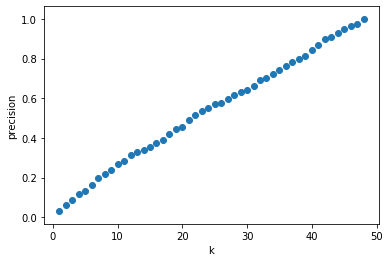

In [35]:
plt.scatter(np.array(list(range(48))) + 1, acc_in_k)
plt.xlabel('k')
plt.ylabel('precision')
plt.show()

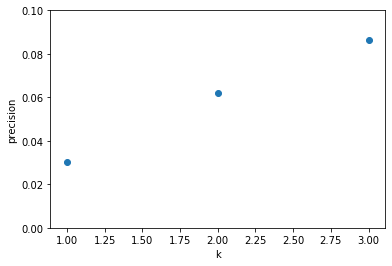

In [36]:
plt.scatter(np.array(list(range(3))) + 1, acc_in_k[:3])
plt.xlabel('k')
plt.ylabel('precision')
plt.ylim(0, 0.1)
plt.show()

In [37]:
for k in range(48):
    print(f"K: {k + 1} - {acc_in_k[k]}")

K: 1 - 0.0302
K: 2 - 0.0619
K: 3 - 0.0862
K: 4 - 0.1148
K: 5 - 0.1307
K: 6 - 0.1632
K: 7 - 0.1962
K: 8 - 0.2181
K: 9 - 0.2389
K: 10 - 0.2671
K: 11 - 0.2824
K: 12 - 0.3129
K: 13 - 0.3294
K: 14 - 0.3397
K: 15 - 0.3549
K: 16 - 0.3756
K: 17 - 0.3911
K: 18 - 0.4215
K: 19 - 0.4431
K: 20 - 0.4573
K: 21 - 0.4882
K: 22 - 0.5178
K: 23 - 0.538
K: 24 - 0.5533
K: 25 - 0.5685
K: 26 - 0.5778
K: 27 - 0.5953
K: 28 - 0.6159
K: 29 - 0.6298
K: 30 - 0.6439
K: 31 - 0.6614
K: 32 - 0.6911
K: 33 - 0.704
K: 34 - 0.7237
K: 35 - 0.7434
K: 36 - 0.7631
K: 37 - 0.7833
K: 38 - 0.7967
K: 39 - 0.8116
K: 40 - 0.8432
K: 41 - 0.8684
K: 42 - 0.8977
K: 43 - 0.9102
K: 44 - 0.9293
K: 45 - 0.9481
K: 46 - 0.9626
K: 47 - 0.9762
K: 48 - 1.0


Похоже на случайные предсказания...

Можно померить, долю попаданий в нужный квадрат или один из квадратов вокруг. 

То есть что квадрат с максимальной вероятностью - один из этих.

Или что квадрат с k - 1 максимальной вероятностью один из этих, или что k - 2.

In [38]:
cell_probs

array([2.09297590e-02, 6.92528773e-13, 1.28117823e-03, 1.45103989e-02,
       2.12452412e-02, 2.23148144e-02, 2.28707627e-02, 2.31612389e-02,
       2.12625576e-02, 1.87848430e-02, 1.63956187e-02, 1.87502165e-02,
       2.14780081e-02, 2.22821112e-02, 2.28342120e-02, 2.30650567e-02,
       2.14337655e-02, 2.09316822e-02, 2.01006476e-02, 2.10701879e-02,
       2.15376449e-02, 2.22609515e-02, 2.24879487e-02, 2.29457874e-02,
       2.19877886e-02, 2.15895845e-02, 2.15376449e-02, 2.15895845e-02,
       2.19877886e-02, 2.22917315e-02, 2.24841012e-02, 2.29188560e-02,
       2.23513662e-02, 2.22821133e-02, 2.20397282e-02, 2.21436075e-02,
       2.23859926e-02, 2.23340529e-02, 2.26379969e-02, 2.29342449e-02,
       2.24379333e-02, 2.24725587e-02, 2.24898719e-02, 2.24552455e-02,
       2.24033058e-02, 2.25418116e-02, 2.28188231e-02, 2.29496349e-02])

In [39]:
argsort = np.argsort(cell_probs)[::-1]

In [40]:
center_point_id

38

In [41]:
# 8 точек вокруг
def find_points_ids_around(center_point_id, bigger_side_blocks_count, max_center_point_id):
    """
    max_center_point_id = 47, если сетка 6x8
    """
    
    points_ids_around = [center_point_id]
    # всегда нужно проверять, что не вышли за границы
    
    point_left = None
    point_right = None
    
    if center_point_id % bigger_side_blocks_count != 0:
        point_left = center_point_id - 1
        points_ids_around.append(point_left)
    
    if center_point_id % bigger_side_blocks_count != (bigger_side_blocks_count - 1):
        point_right = center_point_id + 1
        points_ids_around.append(point_right)
        
    point_up = center_point_id - bigger_side_blocks_count
    if point_up >= 0:
        points_ids_around.append(point_up)
    
    point_down = center_point_id + bigger_side_blocks_count
    if point_down <= max_center_point_id:
        points_ids_around.append(point_down)
        
    if point_left is not None and point_up > 0: 
        # слева сверху
        points_ids_around.append(point_up - 1)
        
    if point_right is not None and point_down < max_center_point_id:
        # справа снизу
        points_ids_around.append(point_down + 1)

    if point_left is not None and point_down <= max_center_point_id:
        # слева снизу
        points_ids_around.append(point_down - 1)
        
    if point_right is not None and point_up >= 0:
        # справа сверху
        points_ids_around.append(point_up + 1)
        
    return points_ids_around

In [42]:
find_points_ids_around(47, bigger_side_blocks_count=8, max_center_point_id=47)

[47, 46, 39, 38]

In [165]:
# Теперь для каждой точки из points найдём точки вокруг

In [43]:
points_around = []
for point in points:
    center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[point][::-1])
    points_around.append(find_points_ids_around(center_point_id, bigger_side_blocks_count, max_center_point_id=47))

In [44]:
points_around = np.array(points_around)

In [45]:
points_around[0]

[38, 37, 39, 30, 46, 29, 47, 45, 31]

In [46]:
def is_in_one_of_max_k_around(cell_probs, p_around, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] in p_around:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [47]:
is_in_one_of_max_k_around(cell_probs, points_around[0], max_k=48)

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [48]:
def is_in_points_around_in_ks_for_one_image(img_id, max_k=48):
    """
    Проверям, попали ли мы в одну из точек вокруг с наибольшей вероятностью?
    А с одной из двух наибольших вероятностей?
    А с одной из трёх?
    И так для всех до max_k
    """
    
    filename_pickle = img_id + '.pickle'
    img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    is_in_k_one_image = []
    
    for i in range(len(points)):
        agent_point = points[i]
        agent_point = agent_point[::-1]
        p_around = points_around[i]

        img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
        img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point[::-1]][::-1])
        
        is_in_k_one_point = is_in_one_of_max_k_around(cell_probs, p_around, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [49]:
%%time
res = is_in_points_around_in_ks_for_one_image(test_ids[0])

CPU times: user 36.7 s, sys: 32 ms, total: 36.8 s
Wall time: 36.7 s


In [50]:
one_img_res = []

for i in range(47):
    one_img_res.append(np.array(res)[:, i].sum() / len(res))

(0, 1.047)

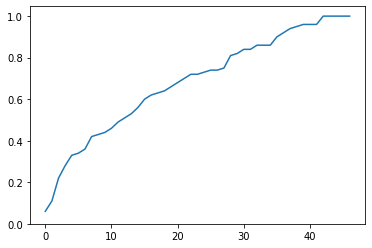

In [51]:
plt.plot(list(range(47)), one_img_res)
plt.ylim(0)

In [52]:
%%time
# А теперь для всех картинок!

is_in_k_around = []

for img_id in test_ids[:100]:
    
    is_in_k_around += is_in_points_around_in_ks_for_one_image(img_id, max_k=48)
    
    if len(is_in_k_around) % 1000 == 0:
        print(len(is_in_k_around))
        

../utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 38min, sys: 1.44 s, total: 38min 1s
Wall time: 38min 2s


In [53]:
is_in_k_around = np.array(is_in_k_around)

In [54]:
np.save("../dataset/is_in_k_6_8_around.npy", is_in_k_around)

In [55]:
acc_in_k_around = []
for i in range(48):
    acc_in_k_around.append(is_in_k_around[:, i].sum() / is_in_k_around.shape[0])

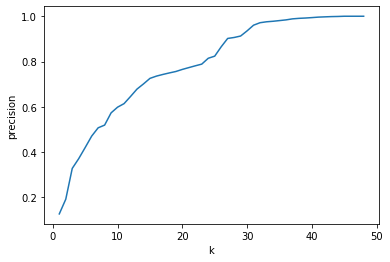

In [56]:
plt.plot(np.array(list(range(48))) + 1, acc_in_k_around)
plt.xlabel('k')
plt.ylabel('precision')
plt.show()

In [57]:
for k in range(48):
    print(f"K: {k + 1} - {acc_in_k_around[k]}")

K: 1 - 0.1267
K: 2 - 0.1916
K: 3 - 0.3277
K: 4 - 0.3709
K: 5 - 0.4201
K: 6 - 0.4704
K: 7 - 0.5071
K: 8 - 0.5191
K: 9 - 0.5732
K: 10 - 0.5983
K: 11 - 0.6139
K: 12 - 0.6455
K: 13 - 0.6782
K: 14 - 0.701
K: 15 - 0.7255
K: 16 - 0.7355
K: 17 - 0.7429
K: 18 - 0.7496
K: 19 - 0.7559
K: 20 - 0.7651
K: 21 - 0.7731
K: 22 - 0.781
K: 23 - 0.7885
K: 24 - 0.8143
K: 25 - 0.8237
K: 26 - 0.865
K: 27 - 0.9019
K: 28 - 0.9062
K: 29 - 0.9126
K: 30 - 0.9354
K: 31 - 0.9605
K: 32 - 0.9714
K: 33 - 0.9755
K: 34 - 0.9778
K: 35 - 0.9808
K: 36 - 0.9839
K: 37 - 0.9884
K: 38 - 0.9907
K: 39 - 0.9921
K: 40 - 0.994
K: 41 - 0.9961
K: 42 - 0.9973
K: 43 - 0.9984
K: 44 - 0.999
K: 45 - 1.0
K: 46 - 1.0
K: 47 - 1.0
K: 48 - 1.0


In [200]:
1 / 48

0.020833333333333332

In [201]:
9 / 48

0.1875

Получаем по сути случайность

Для приличия посчитаем ещё и для 3x4, но там, скорее всего будет то же самое.

Есть идея выделить картинки, на которых должно работать лучше чем рандом.

Случаи, когда нельзя сделать лучше, чем рандом:

- на картинке только 1 объект
- на картинке нет объектов

P.S. valley и ridge не используются, так что их выкидываем - считаем, что объектов нет

Ещё один случай, в котором, скорее всего, ничего не будет работать - на картинке остаются объекты только одного типа и их очень много